## Libraries

In [ ]:
import os, sys, glob
from osgeo import gdal, osr, ogr
import rasterio as rio
import netCDF4
import itertools, re
from datetime import datetime
import numpy as np
from joblib import Parallel, delayed
import io
import operator
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import xgboost as xgb
from xgboost import dask as dxgb
import pickle
from sklearn.kernel_approximation import Nystroem
from sklearn.gaussian_process.kernels import Matern
import pyproj

# from dask import delayed, compute, distributed
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [3]:
import Global_Functions
import Gdal_Functions

In [48]:
local_path = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
data = pd.read_csv(f'{local_path}/Siberia/PeatFire/BG_CC/data/Data_Emissions_Modelling.csv', index_col='Unnamed: 0')
clim = [
 'Tmax_terra',
 'Tmax_anomaly',
 'Tmin_terra',
 'Tmin_anomaly',
 'VPD_terra',
 'VPD_anomaly',
 'solar_down_terra',
 'solar_down_anomaly',
 'pdsi',
 'pdsi_anomaly',
 'cwd',
 'cwd_anomaly',
'moisture_terra',
 'moisture_anomaly',
 'duff_moisture',
 'finefuel_moisture',
 'FWI',
 'duff_moisture_anomaly',
 'finefuel_moisture_anomaly',
 'FWI_anomaly',
]

variables = ['post_NBR', 'post_NBR2','diff_NBR', 'diff_NBR2', 'FRP',
               'JD', 'BA_patch', 'duration', 'sand', 'silt', 'clay', 
                *clim,
               'LST', 'LST_anomaly_std', 'LST_persistence',
               'SOC', 'bog', 'fen', 'elevation', 'aspect', 'slope', 
               'tree_cover', 'nontree_cover',
                    'burn_depth', 'bg_c_combusted']
columns = ['post_NBR', 'post_NBR2', 'diff_NBR', 'diff_NBR2', 'FRP', 'JD',
       'BA_patch', 'duration', 'sand', 'silt', 'clay', 'Tmax_terra',
       'Tmax_anomaly', 'Tmin_terra', 'Tmin_anomaly', 'VPD_terra',
       'VPD_anomaly', 'solar_down_terra', 'solar_down_anomaly', 'pdsi',
       'pdsi_anomaly', 'cwd', 'cwd_anomaly', 'moisture_terra',
       'moisture_anomaly', 'duff_moisture', 'finefuel_moisture', 'FWI',
       'duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly',
       'LST', 'LST_anomaly_std', 'LST_persistence', 'SOC', 'bog', 'fen',
       'elevation', 'aspect', 'slope', 'tree_cover', 'nontree_cover',
       'burn_depth', 'bg_c_combusted', 'pred_depth', 'pred_bgc', 'AGB',
       'ag_c_combusted', 'pred_agcc']

df = data[columns]
df = df.reset_index(drop=True)
X, y = df.loc[:, df.columns[:-2]], df[df.columns[-2]]
X

post_NBR  post_NBR2  diff_NBR  diff_NBR2        FRP   JD      BA_patch  \
0     -0.3574     0.0170  -0.87260   -0.31570  17.245178  180  1.022062e+09   
1     -0.2994     0.0407  -0.87790   -0.30450  34.913792  190  1.022062e+09   
2     -0.4611    -0.0848  -0.67450   -0.32060  96.693123  184  1.219686e+09   
3     -0.3597     0.0058  -0.92600   -0.34070  22.635136  193  1.054754e+09   
4      0.0019     0.1676  -0.54780   -0.17335  12.672477  190  1.054754e+09   
..        ...        ...       ...        ...        ...  ...           ...   
891   -0.4762    -0.0828  -1.05180   -0.41315  37.700001  234  1.798731e+08   
892   -0.3051     0.0154  -0.87515   -0.31280  16.600000  236  1.798731e+08   
893   -0.2752     0.0146  -0.94595   -0.30205  16.600000  236  1.798731e+08   
894   -0.4764    -0.0987  -1.08410   -0.43970  37.700001  234  1.798731e+08   
895   -0.4610    -0.1307  -1.10470   -0.46900  37.700001  234  1.798731e+08   

     duration        sand        silt  ...  elevation      aspect      slope  \
0          18  571.666667  249.666667  ...        570  108.024091   4.225210   
1          18  595.000000  253.666667  ...        608   92.605999   5.113978   
2          41  487.000000  265.000000  ...        380   97.984144   3.378998   
3          36  499.000000  271.666667  ...        489   43.177480   0.927410   
4          36  407.000000  339.333333  ...        440   48.909921   1.854334   
..        ...         ...         ...  ...        ...         ...        ...   
891        21  274.000000  613.333333  ...        449  264.583883   6.527001   
892        21  289.000000  608.000000  ...        376  299.772909   9.798939   
893        21  289.000000  608.000000  ...        340  278.376305  19.256453   
894        21  274.000000  613.333333  ...        450  241.158813  13.642695   
895        21  281.666667  607.000000  ...        444  283.377896   5.713710   

     tree_cover  nontree_cover  burn_depth  bg_c_combusted  pred_depth  \
0            29             48         0.0             0.0    9.498026   
1            21             53         0.0             0.0    8.467768   
2            41             34         0.0             0.0   11.371709   
3            45             34         0.7            53.4    5.448076   
4            51             15         0.7            34.9    5.385658   
..          ...            ...         ...             ...         ...   
891          66             13        31.4          8020.4   26.950504   
892          53             28        32.2         10209.4   26.192990   
893          48             33        33.0          8513.9   22.497799   
894          66             13        33.4          8629.3   26.330330   
895          56             37        34.2          8874.7   25.986160   

        pred_bgc  AGB  
0    3651.447910  136  
1    3011.933091  137  
2    3363.421106   89  
3    2822.660645   43  
4    1708.030364   37  
..           ...  ...  
891  6761.248721   36  
892  7051.375654   73  
893  5446.412729  112  
894  6423.989153   50  
895  6856.913584   33  

[896 rows x 47 columns]

<AxesSubplot: >

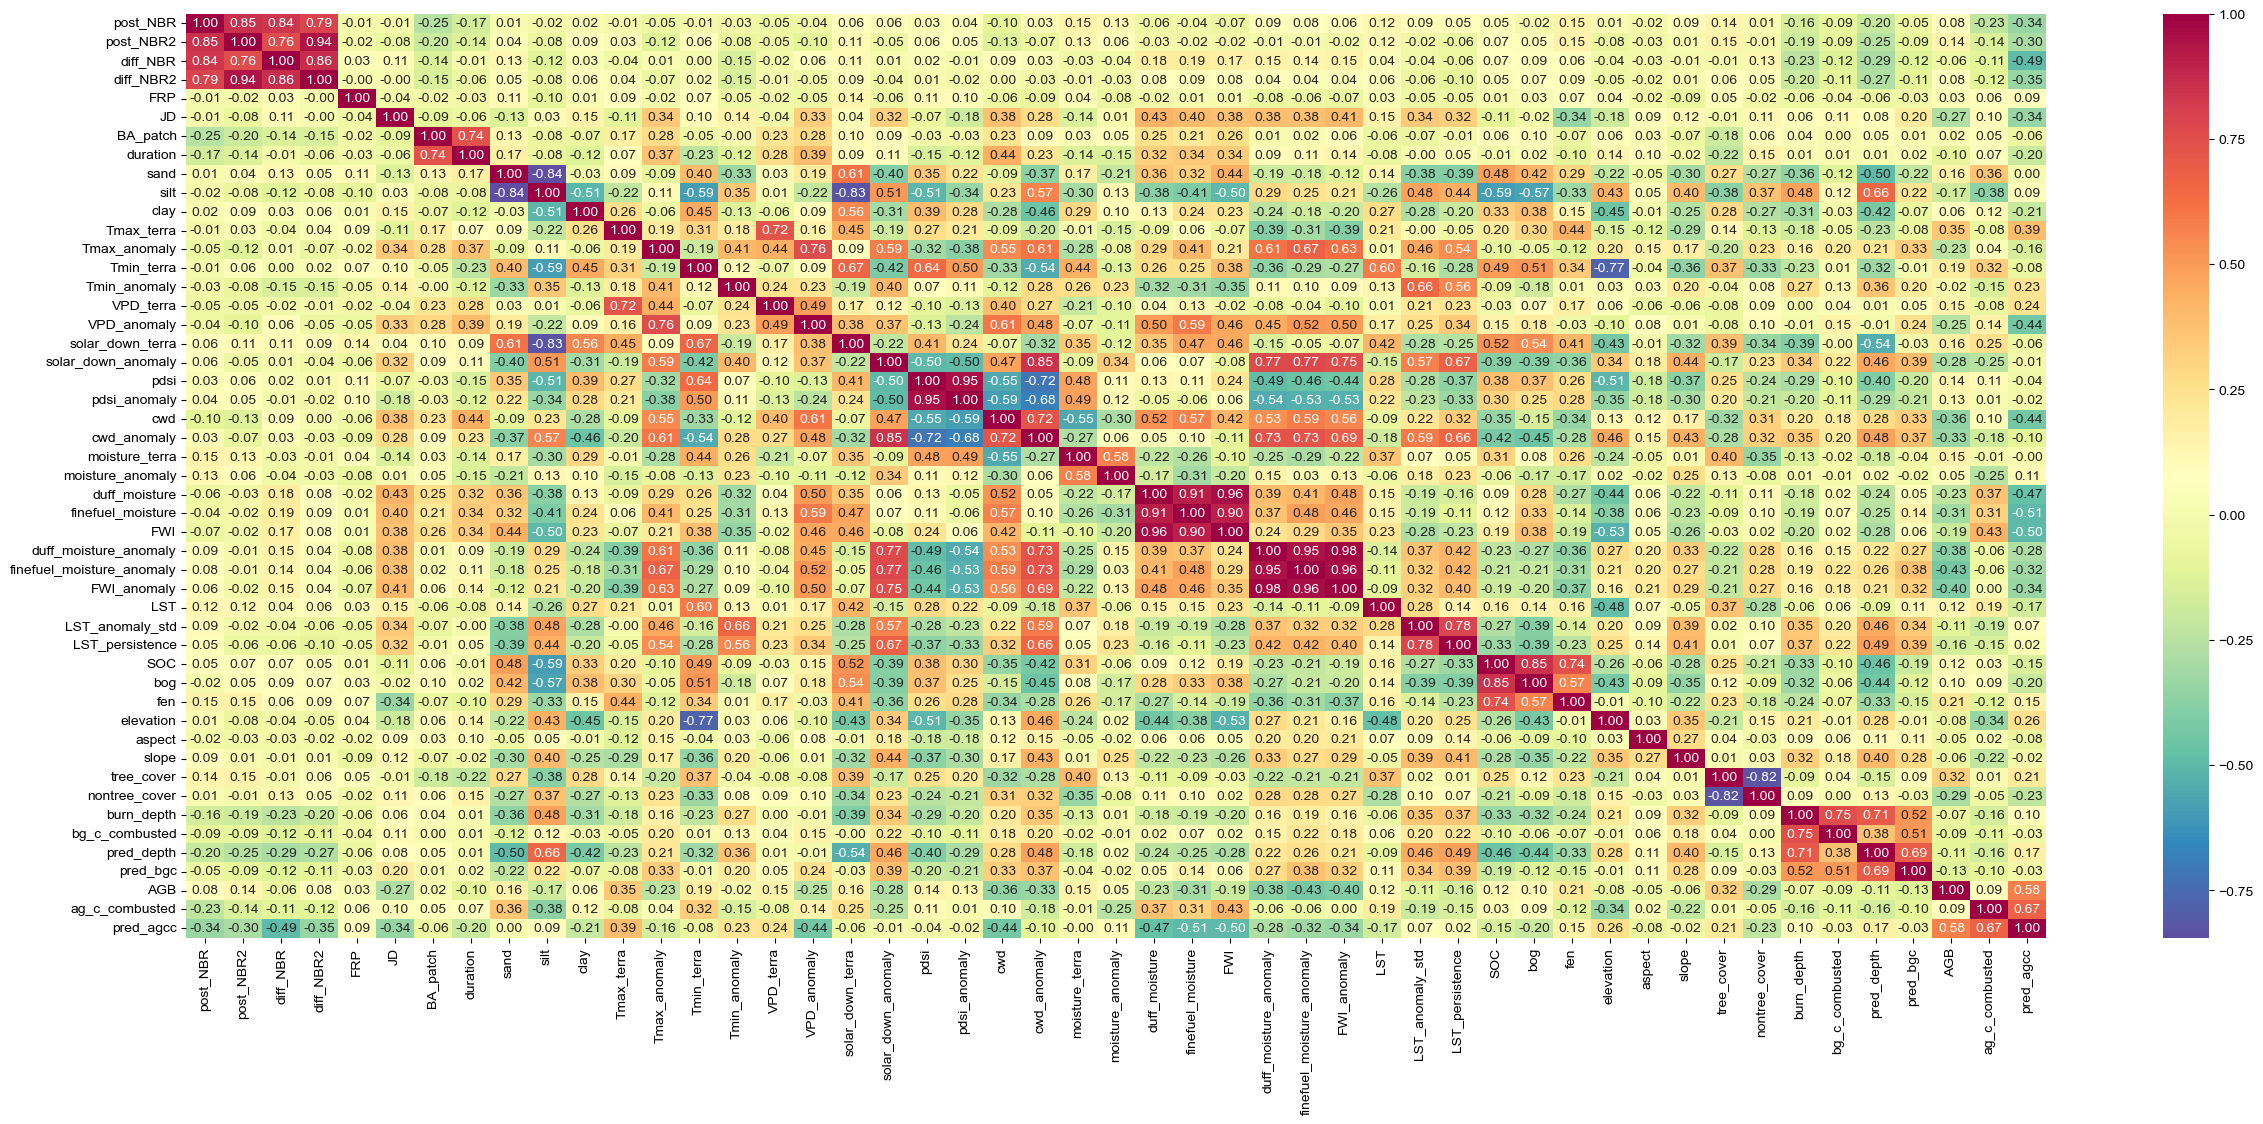

In [49]:
fig, ax = plt.subplots(figsize=(30, 12))
corrMatrix = df.corr(method='pearson')
sns.heatmap(corrMatrix, annot=True, fmt='.02f', cmap='Spectral_r')

## Model inputs

In [5]:
local_path = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
trials_depth = pickle.load(open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_depth.pkl', 'rb'))
best_depth_hopt = trials_depth.argmin
best_depth_hopt.update({"objective": "reg:squarederror", 
          'tree_method':'hist',
          'device': 'cuda', 
          #  'updater': 'grow_gpu_hist',        # GPU-enabled updater
          'nthread': 1,
          'eval_metric':'rmse',
          # 'n_jobs': 18
              })
trials_bgc = pickle.load(open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_bgc.pkl', 'rb'))
best_bgc_hopt = trials_bgc.argmin
best_bgc_hopt.update({"objective": "reg:squarederror", 
          'tree_method':'hist',
          'device': 'cuda', 
          #  'updater': 'grow_gpu_hist',        # GPU-enabled updater
          'nthread': 1,
          'eval_metric':'rmse',
          # 'n_jobs': 18
              })
trials = pickle.load(open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_agcc.pkl', 'rb'))
best_agcc_hopt = trials.argmin
best_agcc_hopt.update({"objective": "reg:squarederror", 
          'tree_method':'hist',
          'device': 'cuda', 
          #  'updater': 'grow_gpu_hist',        # GPU-enabled updater
          'nthread': 1,
          'eval_metric':'rmse',
          # 'n_jobs': 18
              })
best_agcc_hopt

{'colsample_bytree': 0.6792652555522787,
 'gamma': 4.146091751594208,
 'learning_rate': 0.17544278207725614,
 'max_depth': 8,
 'min_child_weight': 2.0,
 'reg_alpha': 8.98522379547516,
 'reg_lambda': 4.0431350566457365,
 'subsample': 0.5889031081843417,
 'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'device': 'cuda',
 'nthread': 1,
 'eval_metric': 'rmse'}

In [6]:
best_depth_hopt

{'colsample_bytree': 0.8583066583623611,
 'gamma': 0.25202534307914415,
 'learning_rate': 0.04654086605752556,
 'max_depth': 13,
 'min_child_weight': 5.0,
 'reg_alpha': 1.6986609580956173,
 'reg_lambda': 15.760638486284062,
 'subsample': 0.6056058096420451,
 'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'device': 'cuda',
 'nthread': 1,
 'eval_metric': 'rmse'}

In [10]:
history_depth = {'n_boost': 145,
 'test-r2-mean': 0.4998602000000001,
 'test-rmse-mean': 3.8066002213620096,
 'test-mae-mean': 2.817806851363807,
 'features': ['diff_NBR2',
  'duration',
  'sand',
  'silt',
  'clay',
  'Tmax_terra',
  'Tmax_anomaly',
  'Tmin_terra',
  'Tmin_anomaly',
  'VPD_anomaly',
  'solar_down_terra',
  'solar_down_anomaly',
  'pdsi_anomaly',
  'cwd_anomaly',
  'moisture_terra',
  'moisture_anomaly',
  'duff_moisture',
  'finefuel_moisture',
  'FWI',
  'LST_anomaly_std',
  'bog',
  'fen',
  'elevation',
  'tree_cover',
  'nontree_cover']}

history_bgc = {'n_boost': 142,
 'test-r2-mean': 0.2401013,
 'test-rmse-mean': 1528.0977711658102,
 'test-mae-mean': 1116.0162292549048,
 'features': ['FWI_anomaly',
  'LST_anomaly_std',
  'SOC',
  'bog',
  'fen',
  'elevation',
  'tree_cover',
  'nontree_cover',
  'pred_depth']}

history_agcc = {'n_boost': 22,
 'test-r2-mean': 0.4300357,
 'test-rmse-mean': 298.0543166948076,
 'test-mae-mean': 196.8304342276029,
 'features': ['post_NBR',
  'diff_NBR',
  'post_NBR2',
  'JD',
  'Tmax_anomaly',
  'Tmin_anomaly',
  'VPD_terra',
  'VPD_anomaly',
  'solar_down_terra',
  'solar_down_anomaly',
  'cwd',
  'moisture_terra',
  'moisture_anomaly',
  'duff_moisture',
  'finefuel_moisture',
  'FWI_anomaly',
  'LST_anomaly_std',
  'SOC',
  'bog',
  'AGB']}

## Models

In [50]:
np.random.seed(42)
X = df[history_depth['features']]
obs_depth = df['burn_depth']
model_depth = xgb.XGBRegressor(n_estimators=history_depth['n_boost'], random_state=42, **best_depth_hopt)
model_depth.fit(X, obs_depth)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8583066583623611, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.25202534307914415,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04654086605752556,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=5.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=145, n_jobs=None, nthread=1,
             num_parallel_tree=None, ...)

(array([ 36., 160., 238., 203., 137.,  61.,  27.,  22.,   4.,   8.]),
 array([ 2.63324642,  5.19424343,  7.75524044, 10.31623745, 12.87723446,
        15.43823242, 17.99922943, 20.56022644, 23.12122345, 25.68222046,
        28.24321747]),
 <BarContainer object of 10 artists>)

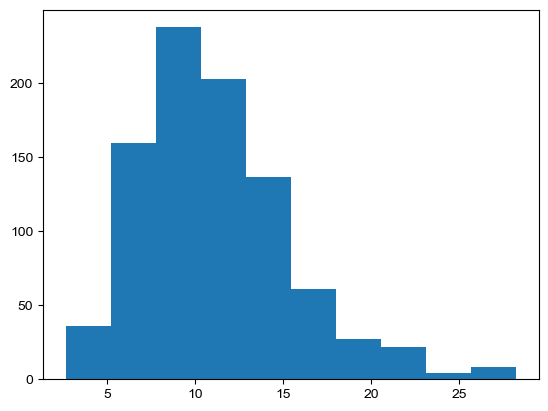

In [13]:
plt.hist(model_depth.predict(X))

In [28]:
np.random.seed(42)
X = df[history_bgc['features']]
obs_bgc = df['bg_c_combusted']
model_bgc = xgb.XGBRegressor(n_estimators=history_bgc['n_boost'], random_state=42, **best_bgc_hopt)
model_bgc.fit(X, obs_bgc)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5539977818438451, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=1.7213866789715178,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01648833874441485,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=142, n_jobs=None, nthread=1,
             num_parallel_tree=None, ...)

In [22]:
model_bgc.predict(X)

array([1982.2688, 1916.3823, 2147.1653, 1490.3752, 1065.0581, 1721.3544,
       1506.2792, 2234.4062, 2623.22  , 1203.0997, 1937.4155, 1266.143 ,
       1059.539 , 1875.1897, 1353.3812, 1778.5839, 2101.8218, 2405.9102,
       1208.3412, 1657.8268, 2492.8813, 1862.6202, 1134.4929, 2987.5085,
       1304.8876, 1954.9375, 2695.7195, 1763.6173, 2338.9243, 1098.1361,
       2212.8174, 1881.8672, 1336.0706, 2261.542 , 1876.226 , 3020.6206,
       1677.2136, 2489.8398, 2400.9868, 2737.1926, 1763.7362, 3600.4502,
       1266.8414, 2945.1428, 1732.5757, 1834.4059, 1506.1714, 1902.1621,
       2461.5608, 1860.3942, 1563.6913, 1395.8027, 1911.7864, 1559.196 ,
       1739.8896, 2070.9072, 1230.2976, 2115.7722, 1249.1702, 2331.8745,
       1625.9258, 1170.6923, 2304.516 , 1437.4712, 1911.5923, 2310.874 ,
       2212.3071, 2112.3828, 3031.1008, 3583.7441, 1930.8619, 1826.6044,
       1420.2712, 2092.799 , 2340.5786, 1923.4675, 2083.4072, 1330.6432,
       1922.904 , 1896.4558, 1969.1947, 2644.028 , 

(array([ 36., 186., 259., 219., 105.,  52.,  14.,  13.,   4.,   8.]),
 array([1059.53894043, 1711.5604248 , 2363.58203125, 3015.60351562,
        3667.625     , 4319.64648438, 4971.66796875, 5623.68945312,
        6275.7109375 , 6927.73242188, 7579.75390625]),
 <BarContainer object of 10 artists>)

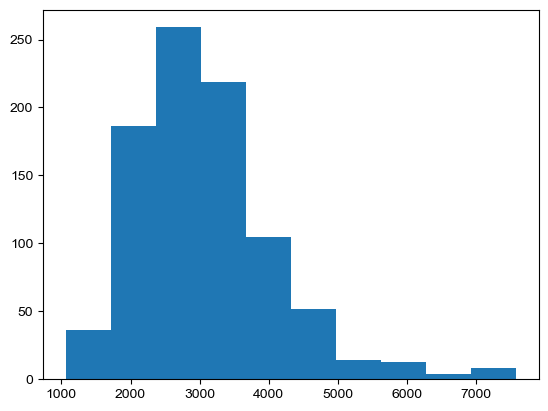

In [23]:
plt.hist(model_bgc.predict(X))

In [29]:
np.random.seed(42)
df2 = df.copy().query('ag_c_combusted >= 0 & ag_c_combusted < 5000').drop(columns=['bg_c_combusted', 'burn_depth'])
X = df2[history_agcc['features']]
obs_agcc = df2['ag_c_combusted']
obs_agcc

0      1719.306
1      2252.180
2      1293.367
3       794.981
4       234.666
         ...   
878      16.589
879     221.455
883    1950.053
886     600.436
887      37.188
Name: ag_c_combusted, Length: 586, dtype: float64

In [30]:
np.random.seed(42)
model_agcc = xgb.XGBRegressor(n_estimators=history_agcc['n_boost'], random_state=42, **best_agcc_hopt)
model_agcc.fit(X, obs_agcc)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6792652555522787, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=4.146091751594208,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.17544278207725614,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=22, n_jobs=None, nthread=1,
             num_parallel_tree=None, ...)

## Predictor collection

In [22]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'

def get_peat_content(tile, local_path):
    names = [
             # 'Histel_fraction', 
             'Histel_SOC_hg_per_sqm', 'Histosol_SOC_hg_per_sqm', 
             'Histel_ombrotrophic', 'Histosol_ombrotrophic', 
             'Histel_minerotrophic', 'Histosol_minerotrophic'
            ]
    cols = [
            # 'permafrost', 
            'permafrost_SOC', 'nonpermafrost_SOC', 
            'permafrost_bog','nonpermafrost_bog', 
            'permafrost_fen','nonpermafrost_fen'
           ]
    ls_bog = []
    ls_fen = []
    ls_SOC = []
    for n, c in zip(names, cols):
        pathname = f'{local_path}/PeatFire/BG_CC/data/Higelius_Peat_properties/{n}_WGS84.nc'
        # print(pathname, n)
        filehandle = netCDF4.Dataset(pathname,'r',format="NETCDF4")
        values = filehandle.variables[f'{n}_WGS84.tif'][:]
        values.mask = False
        values[values==values.fill_value] = 0
        if 'bog' in c:
            # print(f'bog: {c}, {n}')
            ls_bog.append(values)
        elif 'fen' in c:
            # print(f'fen: {c}, {n}')
            ls_fen.append(values)
        elif 'SOC' in c:
            # print(f'SOC: {c}, {n}')
            ls_SOC.append(values)
        else:
            print(f'permafrost: {c}, {n}')
            permafrost = values.copy()
            
    lathandle = filehandle.variables['lat'][:]
    lonhandle = filehandle.variables['lon'][:]
    lats = np.round(lathandle[:], 2)
    lons = np.round(lonhandle[:], 2)
    xres = np.round(lons[1] - lons[0], 5)
    yres = np.round(lats[1] - lats[0], 5)
    xmin, ymin, xmax, ymax = int(tile[8:11]), int(tile[5:7])-2, int(tile[8:11])+3, int(tile[5:7])
    try:
        index_lon = slice(np.argwhere(lons==xmin+(xres/2))[0, 0], np.argwhere(lons==xmax+(xres/2))[0, 0])
    except:
        if xmax == 180:
            index_lon = slice(np.argwhere(lons==xmin+(xres/2))[0, 0], None)
    index_lat = slice(np.argwhere(lats==ymax+(yres/2))[0, 0], np.argwhere(lats==ymin+(yres/2))[0, 0])
    SOC = np.sum(ls_SOC, axis=0)[index_lat, index_lon]
    fen = np.sum(ls_fen, axis=0)[index_lat, index_lon]
    bog = np.sum(ls_bog, axis=0)[index_lat, index_lon]

    return {"SOC": SOC, 'bog': bog, 'fen': fen}

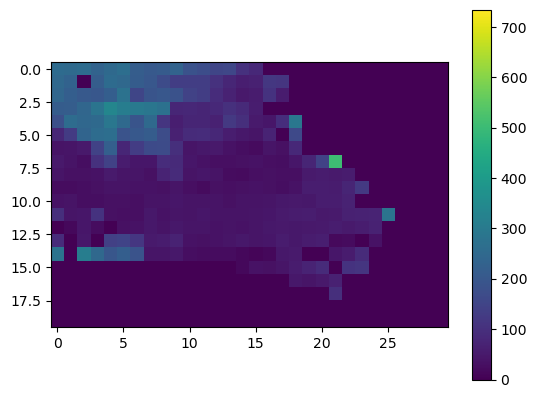

In [15]:
tile = 'TILE-64N177E'
peat = get_peat_content(tile, local_path)
plt.imshow(peat['SOC'], vmin=0, vmax=734)
plt.colorbar()

In [219]:
X.columns

Index(['post_NBR', 'post_NBR2', 'diff_NBR', 'diff_NBR2', 'FRP', 'JD',
       'BA_patch', 'duration', 'sand', 'silt', 'clay', 'Tmax_terra',
       'Tmax_anomaly', 'Tmin_terra', 'Tmin_anomaly', 'VPD_terra',
       'VPD_anomaly', 'solar_down_terra', 'solar_down_anomaly', 'pdsi',
       'pdsi_anomaly', 'cwd', 'cwd_anomaly', 'moisture_terra',
       'moisture_anomaly', 'duff_moisture', 'finefuel_moisture', 'FWI',
       'duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly',
       'LST', 'LST_anomaly_std', 'LST_persistence', 'SOC', 'bog', 'fen',
       'elevation', 'aspect', 'slope', 'tree_cover', 'nontree_cover',
       'burn_depth', 'bg_c_combusted'],
      dtype='object')

In [392]:
peat_content = get_peat_content(tile, local_path)

In [23]:
climate_layers = dict(TerraClimate_Means={'bands': ['Tmax_terra', 'Tmin_terra', 'VPD_terra', 
                                            'solar_down_terra', 'pdsi', 'cwd', 'moisture_terra'],
                                 'scales': [0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1]},
             TerraClimate_Anomalies={'bands': ['Tmax_anomaly', 'Tmin_anomaly', 'VPD_anomaly', 
                                       'solar_down_anomaly',  'pdsi_anomaly', 'cwd_anomaly','moisture_anomaly']},
             ECMWF_CEMS_Means={'bands': ['duff_moisture', 'finefuel_moisture', 'FWI']},
             ECMWF_CEMS_Anomalies={'bands': ['duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly']},
                     )
tiled_layers = dict(MOD44B_VCF={'bands': ['tree_cover', 'nontree_cover']},
             ALOSDEM30={'bands': ['elevation', 'aspect', 'slope']},
             NBR={'bands': ['post_NBR', 'post_NBR2', 'diff_NBR', 'diff_NBR2'],
                 'scales': [-1e-4, -1e-4, -1e-4, -1e-4]},
             LST_Mean={'bands': ['LST'], 'scales': [0.02]}, 
             LST_std_anomaly={'bands': ['LST_anomaly_std']}, 
             LST_persistence={'bands': ['LST_persistence']},
             SoilGrids_sand={'bands': ['sand']},
             SoilGrids_silt={'bands': ['silt']},
             SoilGrids_clay={'bands': ['clay']},
             AGB2010={'bands': ['AGB']}
                       )

In [ ]:
X.columns

Index(['post_NBR', 'post_NBR2', 'diff_NBR', 'diff_NBR2', 'FRP', 'JD',
       'BA_patch', 'duration', 'sand', 'silt', 'clay', 'Tmax_terra',
       'Tmax_anomaly', 'Tmin_terra', 'Tmin_anomaly', 'VPD_terra',
       'VPD_anomaly', 'solar_down_terra', 'solar_down_anomaly', 'pdsi',
       'pdsi_anomaly', 'cwd', 'cwd_anomaly', 'moisture_terra',
       'moisture_anomaly', 'duff_moisture', 'finefuel_moisture', 'FWI',
       'duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly',
       'LST', 'LST_anomaly_std', 'LST_persistence', 'SOC', 'bog', 'fen',
       'elevation', 'aspect', 'slope', 'tree_cover', 'nontree_cover',
       'burn_depth', 'bg_c_combusted'],
      dtype='object')

In [24]:
def get_climate(tile, year, local_path):
    climate_layers = dict(TerraClimate_Means={'bands': ['Tmax_terra', 'Tmin_terra', 'VPD_terra', 
                                                'solar_down_terra', 'pdsi', 'cwd', 'moisture_terra'],
                                     'scales': [0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1]},
                 TerraClimate_Anomalies={'bands': ['Tmax_anomaly', 'Tmin_anomaly', 'VPD_anomaly', 
                                           'solar_down_anomaly',  'pdsi_anomaly', 'cwd_anomaly','moisture_anomaly']},
                 ECMWF_CEMS_Means={'bands': ['duff_moisture', 'finefuel_moisture', 'FWI']},
                 ECMWF_CEMS_Anomalies={'bands': ['duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly']},
                         )
    climate = {}
    for l in tuple(climate_layers.keys())[:]:
        # print(l)
        ds = gdal.Open(f'{local_path}/PeatFire/BG_CC/data/{l}/{l}_Siberia_{year}.tif')
        gt = ds.GetGeoTransform()
        xmin, ymin, xmax, ymax = int(tile[8:11]), int(tile[5:7])-2, int(tile[8:11])+3, int(tile[5:7])
        index_lat = slice(int((ymax - gt[3])/gt[5]), int((ymin - gt[3])/gt[5]))
        index_lon = slice(int((xmin - gt[0])/gt[1]), int((xmax - gt[0])/gt[1]))
        for i, band in enumerate(climate_layers[l]['bands']):
            climate[band] = ds.GetRasterBand(i+1).ReadAsArray()
            if 'scales' in climate_layers[l].keys():
                # print(band, climate_layers[l]['scales'][i], climate[band].shape)
                climate[band] = climate[band] * climate_layers[l]['scales'][i]
            climate[band] = climate[band][index_lat, index_lon]
        
    return climate

In [483]:
climate['FWI'].shape

(8, 12)

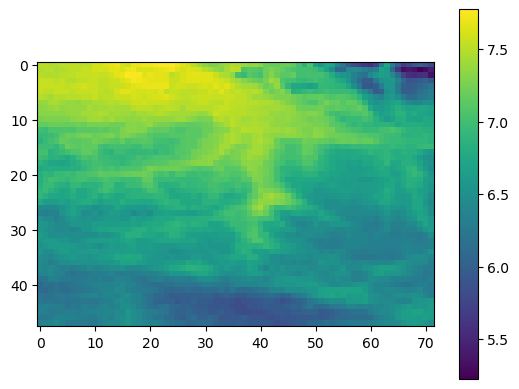

In [18]:
tile = 'TILE-64N126E'
climate = get_climate(tile, 2001, local_path)
plt.imshow(climate['Tmin_terra'])
plt.colorbar()

In [103]:
1/24

0.041666666666666664

## Run predictions

In [25]:
def predict_model(tile, year, local_path, model_depth=None, history_depth=None, 
      model_bgc=None, history_bgc=None, model_agcc=None, history_agcc=None, agg_res=0.25, logfile=False):
# year = 2021
# tile = 'TILE-60N069E'
# agg_res = 0.25
# logfile=False
    if not logfile:
        logfile = io.StringIO()

    os.makedirs(f'{local_path}/PeatFire/ByTile/{tile}/Results', exist_ok=True)
    predictors = {}
    # used_features = history_depth['features'] + history_bgc['features'] + history_agcc['features']
    used_features = history_agcc['features']
    climate_layers = dict(TerraClimate_Means={'bands': ['Tmax_terra', 'Tmin_terra', 'VPD_terra', 
                                            'solar_down_terra', 'pdsi', 'cwd', 'moisture_terra'],
                                 'scales': [0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.1]},
             TerraClimate_Anomalies={'bands': ['Tmax_anomaly', 'Tmin_anomaly', 'VPD_anomaly', 
                                       'solar_down_anomaly',  'pdsi_anomaly', 'cwd_anomaly','moisture_anomaly']},
             ECMWF_CEMS_Means={'bands': ['duff_moisture', 'finefuel_moisture', 'FWI']},
             ECMWF_CEMS_Anomalies={'bands': ['duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly']},
                     )
    tiled_layers = dict(MOD44B_VCF={'bands': ['tree_cover', 'nontree_cover']},
             ALOSDEM30={'bands': ['elevation', 'aspect', 'slope']},
             NBR={'bands': ['post_NBR', 'post_NBR2', 'diff_NBR', 'diff_NBR2'],
                 'scales': [-1e-4, -1e-4, -1e-4, -1e-4]},
             LST_Mean={'bands': ['LST'], 'scales': [0.02]}, 
             LST_std_anomaly={'bands': ['LST_anomaly_std']}, 
             LST_persistence={'bands': ['LST_persistence']},
             SoilGrids_sand={'bands': ['sand']},
             SoilGrids_silt={'bands': ['silt']},
             SoilGrids_clay={'bands': ['clay']},
             AGB2010={'bands': ['AGB']}
                       )
    BA_file = f'{local_path}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_Siberia_Lndst_{year}_{tile}_JD_Correct_Patches.tif'
    ds = gdal.Open(BA_file)
    JD = ds.GetRasterBand(1).ReadAsArray()
    mask_BA = JD > 0
    res = str(agg_res).replace(".", "")
    grid_ref = f'{local_path}/PeatFire/ByTile/{tile}/Grid/BA_Area_{res}D_{tile}_{year}.tif'
    n_BA = np.count_nonzero(mask_BA)
    Global_Functions.print_and_log(logfile, f'\n\t\t{15 * "-"} {tile}: {n_BA} pixels burned {15 * "-"}')  
    if n_BA > 0:
        ds = gdal.Open(f'{local_path}/PeatFire/ByTile/{tile}/Pixel/BA_Peatland_{tile}_{year}.tif')
        peatfire = ds.GetRasterBand(1).ReadAsArray()
        mask_peatfires = peatfire > 0        
        if 'JD' in used_features:
            predictors['JD'] = JD[mask_BA]
        if 'FRP' in used_features:
            ds = gdal.Open(f'{local_path}/ByTile/{tile}/Voronoi/FRP/Hotspots_FRP_{year}_{tile}.tif')
            predictors['FRP'] = ds.GetRasterBand(1).ReadAsArray()[mask_BA]
        
        if np.isin(['duration', 'BA_patch'], used_features).any(): 
            ds = gdal.Open(f"{local_path}/ByTile/{tile}/Patches/TIF/BAMT_BA_Siberia_Lndst_Patches-16_{year}_{tile}.tif")
            labels = ds.GetRasterBand(1).ReadAsArray()
            lookup = pd.read_csv(f"{local_path}/ByTile/{tile}/Patches/Tabular/BAMT_BA_Siberia_Lndst_Patch-Stats-16_{year}_{tile}.csv")
            lookup['id'] = lookup['ID'].apply(lambda x: int(x.split('_')[-1]))
            if 'duration' in used_features:
                predictors['duration'] = Global_Functions.replace_numpy_list(labels[mask_BA], lookup['id'].values, 
                                                             lookup['DURATION'].values)
            else:
                predictors['BA_patch'] = Global_Functions.replace_numpy_list(labels[mask_BA], lookup['id'].values, 
                                                             lookup['AREA'].values)
        
        for l, c in tiled_layers.items():
                if os.path.isfile(f'{local_path}/PeatFire/ByTile/{tile}/Predictors/{l}_Siberia_{year}_{tile}.tif'):
                    ds = gdal.Open(f'{local_path}/PeatFire/ByTile/{tile}/Predictors/{l}_Siberia_{year}_{tile}.tif')
                elif l not in ['ALOSDEM30', 'AGB2010'] and 'SoilGrids' not in l:
                    print(f'{l} is not available for {year}, replaced by 2020')   ### VCF tree/non-tree cover
                    ds = gdal.Open(f'{local_path}/PeatFire/ByTile/{tile}/Predictors/{l}_Siberia_2020_{tile}.tif')
                else:
                    ds = gdal.Open(f'{local_path}/PeatFire/ByTile/{tile}/Predictors/{l}_Siberia_{tile}.tif')
                    
                for i, band in enumerate(tiled_layers[l]['bands']):
                    if band in used_features:
                        predictors[band] = ds.GetRasterBand(i+1).ReadAsArray()[mask_BA]
                        if 'scales' in tiled_layers[l].keys():
                            # print(band, tiled_layers[l]['scales'][i])
                            predictors[band] = predictors[band] * tiled_layers[l]['scales'][i]
                    # else:
                    #     print(f'{band} is not included in the model')
        peat_content = get_peat_content(tile, local_path)
        for l in peat_content.keys():
            if l in used_features:
                scale = 8000 // peat_content[l].shape[0]
                predictors[l] = np.repeat(np.repeat(peat_content[l], scale, 0), scale, 1)[mask_BA]
        climate = get_climate(tile, year, local_path)
        for l in climate.keys():
            if l in used_features:
                ## a maximum of 1/3 of the pixel is shifted towards the end
                scale = round(8000 / climate[l].shape[0])
                predictors[l] = np.repeat(np.repeat(climate[l], scale, 0), scale, 1)[:8000, :12000][mask_BA]
                
        # predictors = dict(sorted(predictors.items(), key=lambda item: history_depth['features'].index(item[0])))
        dmatrix = pd.DataFrame(data=np.column_stack([predictors[key] for key in history_depth['features']]), 
                                  columns=history_depth['features']).astype(np.float32)
        # dmatrix = xgb.DMatrix(data=np.column_stack([predictors[key] for key in history_depth['features']]), 
        #                           feature_names=history_depth['features'])
        if n_BA < 1e7:
            pred_depth = model_depth.predict(dmatrix)
        else:
            Global_Functions.print_and_log(logfile, f'\n *** {n_BA} pixels burned: Use DASK {15 * "-"}')  
            cluster = LocalCluster(n_workers=1, threads_per_worker=1)
            client = Client(cluster)    
            dmatrix = dd.from_pandas(dmatrix, npartitions=int(np.ceil(n_BA / 1e7)))
            pred_depth = dxgb.predict(client, model_depth.get_booster(), dmatrix)
        del dmatrix
        predictors['pred_depth'] = pred_depth
        dmatrix = pd.DataFrame(data=np.column_stack([predictors[key] for key in history_bgc['features']]), 
                                  columns=history_bgc['features']).astype(np.float32)
        # dmatrix = xgb.DMatrix(data=np.column_stack([predictors[key] for key in history_bgc['features']]), 
        #                           feature_names=history_bgc['features'])
        if n_BA < 1e7:
            pred_bgc = model_bgc.predict(dmatrix)
        else: 
            dmatrix = dd.from_pandas(dmatrix, npartitions=int(np.ceil(n_BA / 1e7)))
            pred_bgc = dxgb.predict(client, model_bgc.get_booster(), dmatrix)
            # client.close()
            # cluster.close()
        del dmatrix

        reshaped_depth = np.full(mask_BA.shape, -9999, np.float32)
        reshaped_bgc = np.full(mask_BA.shape, -9999, np.float32)
        reshaped_depth[mask_BA] = pred_depth
        reshaped_bgc[mask_BA] = pred_bgc
        area = Global_Functions.get_pixel_area(BA_file, area_1d=True)
        creation_dict = {'ALL': mask_BA, 
                        'PEAT': mask_peatfires}
        for layer, mask in creation_dict.items():
            if layer == 'PEAT':
                reshaped_depth[~mask] = -9999
                reshaped_bgc[~mask] = -9999
            reshaped_depth = np.ma.masked_where(~mask, reshaped_depth)
            reshaped_bgc = np.ma.masked_where(~mask, reshaped_bgc)
            np.ma.set_fill_value(reshaped_depth, -9999)
            np.ma.set_fill_value(reshaped_bgc, -9999)
            scale = int(agg_res / 0.00025)
            agg_bgc = np.nanmean(reshaped_bgc.reshape(reshaped_bgc.shape[0] // scale, scale, 
                                    reshaped_bgc.shape[1] // scale, scale), axis=(1, 3)) 
            agg_depth = np.nanmean(reshaped_depth.reshape(reshaped_depth.shape[0] // scale, scale, 
                                    reshaped_depth.shape[1] // scale, scale), axis=(1, 3)) 
            np.ma.set_fill_value(agg_bgc, -9999)
            np.ma.set_fill_value(agg_depth, -9999)
            area_bgc = (reshaped_bgc.transpose() * area).transpose() * 1e-6  ## from g to T
            agg_bgc_sum = np.nansum(area_bgc.reshape(area_bgc.shape[0] // scale, scale, 
                                    area_bgc.shape[1] // scale, scale), axis=(1, 3)) 
            # print(layer, agg_bgc_sum[agg_bgc_sum > 0])
            
            Global_Functions.write_rasterio(reshaped_depth, f'{local_path}/PeatFire/ByTile/{tile}/Results/BurnDepth_{layer}_{year}_{tile}.tif',
                                           BA_file, nodata=-9999, custom_dtype=True, dtype='float32')
            Global_Functions.write_rasterio(reshaped_bgc, f'{local_path}/PeatFire/ByTile/{tile}/Results/BGCC-gCm2_{layer}_{year}_{tile}.tif',
                                           BA_file, nodata=-9999, custom_dtype=True, dtype='float32')
            Global_Functions.write_rasterio(agg_bgc_sum, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/BGCC-MgC_SUM_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(agg_bgc, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/BGCC-gCm2_Burned_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(agg_depth, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/BurnDepth_MEAN_{res}D_{layer}_{year}_{tile}.tif')
        
    
        dmatrix = pd.DataFrame(data=np.column_stack([predictors[key] for key in history_agcc['features']]), 
                                  columns=history_agcc['features']).astype(np.float32)
        if n_BA < 1e7:
            pred_agcc = model_agcc.predict(dmatrix)
        else:
            Global_Functions.print_and_log(logfile, f'\n *** {n_BA} pixels burned: Use DASK {15 * "-"}')  
            cluster = LocalCluster(n_workers=1, threads_per_worker=1)
            client = Client(cluster)    
            dmatrix = dd.from_pandas(dmatrix, npartitions=int(np.ceil(n_BA / 1e7)))
            pred_agcc = dxgb.predict(client, model_agcc.get_booster(), dmatrix)
        del dmatrix
        # client.close()
        # cluster.close()

        reshaped_agcc = np.full(mask_BA.shape, -9999, np.float32)
        reshaped_agcc[mask_BA] = pred_agcc
        area = Global_Functions.get_pixel_area(BA_file, area_1d=True)
        creation_dict = {'ALL': mask_BA, 
                        'PEAT': mask_peatfires}
        for layer, mask in creation_dict.items():
            if layer == 'PEAT':
                reshaped_agcc[~mask] = -9999
            reshaped_agcc = np.ma.masked_where(~mask, reshaped_agcc)
            np.ma.set_fill_value(reshaped_agcc, -9999)
            scale = int(agg_res / 0.00025)
            agg_agcc = np.nanmean(reshaped_agcc.reshape(reshaped_agcc.shape[0] // scale, scale, 
                                    reshaped_agcc.shape[1] // scale, scale), axis=(1, 3)) 
            np.ma.set_fill_value(agg_agcc, -9999)
            area_agcc = (reshaped_agcc.transpose() * area).transpose() * 1e-6  ## from g to T
            agg_agcc_sum = np.nansum(area_agcc.reshape(area_agcc.shape[0] // scale, scale, 
                                    area_agcc.shape[1] // scale, scale), axis=(1, 3)) 

            Global_Functions.write_rasterio(reshaped_agcc, f'{local_path}/PeatFire/ByTile/{tile}/Results/AGCC-gCm2_{layer}_{year}_{tile}.tif',
                                           BA_file, nodata=-9999, custom_dtype=True, dtype='float32')
            Global_Functions.write_rasterio(agg_agcc_sum, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/AGCC-MgC_SUM_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(agg_agcc, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/AGCC-gCm2_Burned_MEAN_{res}D_{layer}_{year}_{tile}.tif')
    else:
        reshaped_depth = reshaped_bgc = reshaped_agcc = np.full(mask_BA.shape, -9999, np.float32)
        ds = gdal.Open(grid_ref)
        agg_depth = agg_bgc_sum = agg_bgc = agg_agcc_sum = agg_agcc = np.full((ds.RasterYSize, ds.RasterXSize), -9999, np.float32)
        creation_dict = {'ALL': [], 
                        'PEAT': []}
        for layer, mask in creation_dict.items():
            Global_Functions.write_rasterio(reshaped_depth, f'{local_path}/PeatFire/ByTile/{tile}/Results/BurnDepth_{layer}_{year}_{tile}.tif',
                                           BA_file, nodata=-9999, custom_dtype=True, dtype='float32')
            Global_Functions.write_rasterio(reshaped_bgc, f'{local_path}/PeatFire/ByTile/{tile}/Results/BGCC-gCm2_{layer}_{year}_{tile}.tif',
                                           BA_file, nodata=-9999, custom_dtype=True, dtype='float32')
            Global_Functions.write_rasterio(agg_bgc_sum, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/BGCC-MgC_SUM_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(agg_bgc, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/BGCC-gCm2_Burned_MEAN_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(agg_depth, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/BurnDepth_MEAN_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(reshaped_agcc, f'{local_path}/PeatFire/ByTile/{tile}/Results/AGCC-gCm2_{layer}_{year}_{tile}.tif',
                                           BA_file, nodata=-9999, custom_dtype=True, dtype='float32')
            Global_Functions.write_rasterio(agg_agcc_sum, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/AGCC-MgC_SUM_{res}D_{layer}_{year}_{tile}.tif')
            Global_Functions.write_rasterio(agg_agcc, nodata=-9999, refPath=grid_ref, 
                    OutPath=f'{local_path}/PeatFire/ByTile/{tile}/Results/AGCC-gCm2_Burned_MEAN_{res}D_{layer}_{year}_{tile}.tif')

    Global_Functions.print_and_log(logfile, f'\t\t+++++ Files are saved +++++\n')

    return {'tile': tile, 'text': logfile.getvalue()}
    

In [ ]:
tile = 'TILE-64N126E'
year = 2021
agg_res = 0.25
kwargs = dict(
              model_depth=model_depth, 
              model_bgc=model_bgc, 
              history_depth=history_depth,
              history_bgc=history_bgc,
              model_agcc=model_agcc, 
              history_agcc=history_agcc,              
              agg_res=agg_res)

predict_model(tile, year, local_path, **kwargs, logfile=False)


		--------------- TILE-64N126E: 40323975 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020

 *** 40323975 pixels burned: Use DASK ---------------


Sending large graph of size 38.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++



{'tile': 'TILE-64N126E',
 'text': '\n\t\t--------------- TILE-64N126E: 40323975 pixels burned ---------------\n\n *** 40323975 pixels burned: Use DASK ---------------\n\t\t+++++ Files are saved +++++\n\n'}

In [ ]:
agg_res = 0.25
kwargs = dict(
              model_depth=model_depth, 
              model_bgc=model_bgc, 
              history_depth=history_depth,
              history_bgc=history_bgc,
              model_agcc=model_agcc, 
              history_agcc=history_agcc,              
              agg_res=agg_res)
LogFile = open(f'{local_path}/PeatFire/Logs/Logfile_PeatFire_AGCC_Predictions_{str(agg_res).replace(".", "")}D.txt', 'w')
# LogFile.write(f'{30 * "-"} LogFile of prediction ofAGCC of PeatFires {agg_res}° {30 * "-"}\n\n')
Tiles = os.listdir(f'{local_path}/PeatFire/ByTile')
Years = range(2023, 2000, -1)
time0 = datetime.now()
for year in Years[:]:
    time1 = datetime.now()
    Global_Functions.print_and_log(LogFile, f'\n\n{10 * "#"} Processing of Year: {year} {10 * "#"}\n\n')
    listdict = Parallel(n_jobs=2, verbose=100, backend='threading') (delayed (predict_model) (tile, year, local_path, **kwargs) for tile in Tiles[:])
    listdict.sort(key=operator.itemgetter('tile'))
    [LogFile.write(listdict[i]['text']) for i in range(len(listdict))]
    time2 = datetime.now()
    delta = time2 - time1
    hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
    Global_Functions.print_and_log(LogFile, '\n\n%s Year %s is processed in %s hours, %s minutes, %s seconds %s '
                              %(10 *'+', year, hours, minutes, seconds, 10 * '+'))    
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()



########## Processing of Year: 2023 ##########


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.

		--------------- TILE-60N111E: 16546 pixels burned ---------------

		--------------- TILE-68N132E: 5246 pixels burned ---------------
MOD44B_VCF is not available for 2023, replaced by 2020
MOD44B_VCF is not available for 2023, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   19.5s

		--------------- TILE-70N123E: 2475 pixels burned ---------------
MOD44B_VCF is not available for 2023, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   20.9s

		--------------- TILE-70N141E: 9611 pixels burned ---------------
MOD44B_VCF is not available for 2023, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   38.4s
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   39.6s

		-----

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45681 instead
Sending large graph of size 13.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.8min

		--------------- TILE-72N117E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:  1.8min

		--------------- TILE-72N105E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:  1.9min

		--------------- TILE-70N126E: 22823 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.1min

		--------------- TILE-62N153E: 567345 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:  2.2min

		--------------- TILE-62N165E: 2843800 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Par

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37101 instead
Sending large graph of size 38.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.8min

		--------------- TILE-60N156E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:  3.9min

		--------------- TILE-70N156E: 105 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  25 tasks      | elapsed:  4.1min

		--------------- TILE-66N117E: 18080096 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020

 *** 18080096 pixels burned: Use DASK ---------------


Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34139 instead


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  26 tasks      | elapsed:  4.4min

		--------------- TILE-64N105E: 796340 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020


Sending large graph of size 17.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  27 tasks      | elapsed:  4.6min

		--------------- TILE-64N063E: 189558 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.8min

		--------------- TILE-60N066E: 779949 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  29 tasks      | elapsed:  4.9min

		--------------- TILE-64N108E: 904335 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.1min

		--------------- TILE-66N111E: 448573 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  31 tasks      | elapsed:  5.2min

		--------------- TILE-68N144E: 1127152

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44837 instead
Sending large graph of size 12.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 136 tasks      | elapsed: 18.4min

		--------------- TILE-68N153E: 188279 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 137 tasks      | elapsed: 18.5min

		--------------- TILE-68N063E: 732 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed: 18.7min

		--------------- TILE-66N120E: 14015430 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 139 tasks      | elapsed: 18.8min

		--------------- TILE-72N093E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 140 tasks      | elapsed: 18.9min

		--------------- TILE-60N117E: 761909 pixels burned ---------------
MOD44B_VCF is not available for

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38159 instead
Sending large graph of size 13.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 19.1min

		--------------- TILE-66N081E: 6318 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed: 19.3min

		--------------- TILE-64N093E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 143 tasks      | elapsed: 19.4min

		--------------- TILE-70N147E: 356843 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 144 tasks      | elapsed: 19.4min

		--------------- TILE-72N066E: 334 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 145 tasks      | elapsed: 19.7min

		--------------- TILE-70N069E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44011 instead
Sending large graph of size 11.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 154 tasks      | elapsed: 20.9min

		--------------- TILE-66N072E: 30 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 155 tasks      | elapsed: 21.2min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed: 21.2min

		--------------- TILE-70N081E: 2352 pixels burned ---------------

		--------------- TILE-68N141E: 342941 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 157 tasks      | elapsed: 21.5min

		--------------- TILE-66N108E: 641734 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 21.5min
MOD44B_VCF is not available for 2021, replaced by 2020

		--------------- TILE-66N144E: 345546 pixels

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37325 instead
Sending large graph of size 13.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 180 tasks      | elapsed: 24.6min

		--------------- TILE-64N165E: 383552 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 181 tasks      | elapsed: 24.8min

		--------------- TILE-74N114E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 182 tasks      | elapsed: 24.9min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 183 tasks      | elapsed: 24.9min

		--------------- TILE-72N132E: 21096 pixels burned ---------------

		--------------- TILE-68N111E: 0 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 184 tasks      | elapsed: 24.9min

		--------------- TILE-64N111E: 15360965 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Pa

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39007 instead
Sending large graph of size 14.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 186 tasks      | elapsed: 25.4min

		--------------- TILE-70N162E: 1263401 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 187 tasks      | elapsed: 25.7min

		--------------- TILE-72N147E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 188 tasks      | elapsed: 25.7min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 189 tasks      | elapsed: 25.7min

		--------------- TILE-72N075E: 0 pixels burned ---------------

		--------------- TILE-72N099E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 190 tasks      | elapsed: 25.8min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 191 tasks      | elapsed: 25.8min

		--------------- TILE-68N114E: 0 pixels burned ---------------

		--------------- TILE-62N105E: 4318954 pixels burned -------

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43599 instead
Sending large graph of size 10.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 266 tasks      | elapsed: 34.1min

		--------------- TILE-64N102E: 93072 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 267 tasks      | elapsed: 34.2min

		--------------- TILE-74N111E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 268 tasks      | elapsed: 34.3min

		--------------- TILE-70N135E: 137719 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 269 tasks      | elapsed: 34.5min

		--------------- TILE-72N138E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed: 34.5min

		--------------- TILE-66N066E: 27 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36741 instead
Sending large graph of size 16.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 277 tasks      | elapsed: 35.4min

		--------------- TILE-70N171E: 116234 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 278 tasks      | elapsed: 35.7min

		--------------- TILE-70N132E: 132735 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 279 tasks      | elapsed: 35.7min

		--------------- TILE-64N159E: 1295961 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 280 tasks      | elapsed: 36.0min

		--------------- TILE-66N132E: 1080507 pixels burned ---------------
MOD44B_VCF is not available for 2021, replaced by 2020
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 281 tasks      | elapsed: 36.0min

		--------------- TILE-60N126E: 33880

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35339 instead


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.1s

		--------------- TILE-70N123E: 636972 pixels burned ---------------


Sending large graph of size 14.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   32.1s

		--------------- TILE-70N141E: 1835939 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   40.7s

		--------------- TILE-60N108E: 1275246 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   51.6s

		--------------- TILE-70N177E: 11243 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:  1.0min

		--------------- TILE-70N075E: 9755 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.2min

		--------------- TILE-62N111E: 40878 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:  1.3min

		--------------- TILE-68N084E: 8683 pixels burned ---------------
		+++++ Files are saved +++++

[

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44131 instead
Sending large graph of size 10.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.6min

		--------------- TILE-66N096E: 733872 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:  5.9min

		--------------- TILE-70N153E: 3361702 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.9min

		--------------- TILE-70N165E: 90393 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  40 tasks      | elapsed:  6.2min

		--------------- TILE-64N138E: 172149 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  41 tasks      | elapsed:  6.3min

		--------------- TILE-62N126E: 2009415 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  42 tasks      | elapsed:  6.5min

		--------------- TILE-68N129E: 1800897 pixels burned ---------------
		+++++ Files are saved ++

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32953 instead
Sending large graph of size 12.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  75 tasks      | elapsed: 10.5min

		--------------- TILE-72N081E: 33 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  76 tasks      | elapsed: 10.8min

		--------------- TILE-68N069E: 19048 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  77 tasks      | elapsed: 10.8min

		--------------- TILE-64N150E: 824092 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  78 tasks      | elapsed: 11.1min

		--------------- TILE-66N168E: 253328 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  79 tasks      | elapsed: 11.1min

		--------------- TILE-62N120E: 2996115 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  80 tasks      | elapsed: 11.3min

		--------------- TILE-70N138E: 765985 pixels burned ---------------
		+++++ Files are saved +++++

[

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39905 instead
Sending large graph of size 20.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  93 tasks      | elapsed: 13.1min

		--------------- TILE-64N084E: 23721 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 13.3min

		--------------- TILE-60N090E: 5160 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  95 tasks      | elapsed: 13.5min

		--------------- TILE-68N090E: 4636 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  96 tasks      | elapsed: 13.6min

		--------------- TILE-74N096E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  97 tasks      | elapsed: 13.7min

		--------------- TILE-64N144E: 95454 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  98 tasks      | elapsed: 13.8min

		--------------- TILE-68N177E: 13023 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34295 instead
Sending large graph of size 10.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 159 tasks      | elapsed: 22.5min

		--------------- TILE-66N129E: 1893502 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 160 tasks      | elapsed: 22.7min

		--------------- TILE-68N087E: 4537 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 161 tasks      | elapsed: 22.8min

		--------------- TILE-70N102E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 162 tasks      | elapsed: 22.8min

		--------------- TILE-68N081E: 28272 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 163 tasks      | elapsed: 23.0min

		--------------- TILE-60N063E: 104327 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed: 23.1min

		--------------- TILE-62N135E: 2799096 pixels burned ---------------
		+++++ Files are saved +++++

[Pa

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36799 instead
Sending large graph of size 18.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 239 tasks      | elapsed: 32.8min

		--------------- TILE-74N090E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 240 tasks      | elapsed: 32.9min

		--------------- TILE-66N165E: 218577 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 241 tasks      | elapsed: 33.1min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 242 tasks      | elapsed: 33.2min

		--------------- TILE-74N075E: 0 pixels burned ---------------

		--------------- TILE-62N141E: 24218 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 243 tasks      | elapsed: 33.2min

		--------------- TILE-74N084E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 244 tasks      | elapsed: 33.2min

		--------------- TILE-62N063E: 1581867 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42495 instead
Sending large graph of size 11.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 250 tasks      | elapsed: 33.0min

		--------------- TILE-74N141E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 251 tasks      | elapsed: 33.1min

		--------------- TILE-74N120E: 6814 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 252 tasks      | elapsed: 33.4min

		--------------- TILE-60N165E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 253 tasks      | elapsed: 33.4min

		--------------- TILE-70N105E: 30 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 254 tasks      | elapsed: 33.4min

		--------------- TILE-60N102E: 2440730 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 255 tasks      | elapsed: 33.7min

		--------------- TILE-62N129E: 713301 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32817 instead
Sending large graph of size 11.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed: 35.8min

		--------------- TILE-66N066E: 4304 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 271 tasks      | elapsed: 36.0min

		--------------- TILE-74N087E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 272 tasks      | elapsed: 36.0min

		--------------- TILE-66N147E: 113956 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 273 tasks      | elapsed: 36.1min

		--------------- TILE-70N111E: 38314 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 274 tasks      | elapsed: 36.3min

		--------------- TILE-60N159E: 20286 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 275 tasks      | elapsed: 36.4min

		--------------- TILE-64N114E: 2355944 pixels burned ---------------
		+++++ Files are saved +++++

[Para

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34659 instead
Sending large graph of size 22.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  27 tasks      | elapsed:  4.3min

		--------------- TILE-64N063E: 10779 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.5min

		--------------- TILE-60N066E: 115457 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  29 tasks      | elapsed:  4.8min

		--------------- TILE-64N108E: 298296 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.8min

		--------------- TILE-66N111E: 602876 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  31 tasks      | elapsed:  5.1min

		--------------- TILE-68N144E: 99654 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  32 tasks      | elapsed:  5.1min

		--------------- TILE-62N108E: 337717 pixels burned ---------------
		+++++ Files are saved +++++


Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45219 instead


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  17 tasks      | elapsed:  2.7min

		--------------- TILE-70N078E: 21271 pixels burned ---------------


Sending large graph of size 10.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:  3.0min

		--------------- TILE-60N093E: 26501 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  19 tasks      | elapsed:  3.1min

		--------------- TILE-70N066E: 1678 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  20 tasks      | elapsed:  3.3min

		--------------- TILE-64N126E: 889797 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.4min

		--------------- TILE-68N117E: 2073 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  22 tasks      | elapsed:  3.6min

		--------------- TILE-64N096E: 144044 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.7min

		--------------- TILE-60N156E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parall

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43491 instead
Sending large graph of size 9.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 289 out of 289 | elapsed: 38.5min finished


++++++++++ Year 2016 is processed in 0.0 hours, 38.0 minutes, 28.731624999999894 seconds ++++++++++ 


########## Processing of Year: 2015 ##########


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.

		--------------- TILE-68N132E: 55588 pixels burned ---------------

		--------------- TILE-60N111E: 202037 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   19.6s

		--------------- TILE-70N123E: 2051 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   20.8s

		--------------- TILE-70N141E: 5287 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   39.0s

		--------------- TILE-60N108E: 64987 pixels burned ---------------
		+++++ Files 

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33011 instead
Sending large graph of size 11.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed:  2.9min

		--------------- TILE-60N093E: 552428 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  19 tasks      | elapsed:  3.2min

		--------------- TILE-70N066E: 1156 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  20 tasks      | elapsed:  3.2min

		--------------- TILE-64N126E: 3708484 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.5min

		--------------- TILE-68N117E: 36775 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  22 tasks      | elapsed:  3.6min

		--------------- TILE-64N096E: 107464 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.8min

		--------------- TILE-60N156E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Par

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34057 instead
Sending large graph of size 16.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 180 tasks      | elapsed: 24.5min

		--------------- TILE-64N165E: 916 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 181 tasks      | elapsed: 24.8min

		--------------- TILE-74N114E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 182 tasks      | elapsed: 24.8min

		--------------- TILE-72N132E: 566430 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 183 tasks      | elapsed: 24.9min

		--------------- TILE-68N111E: 5111 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 184 tasks      | elapsed: 25.2min

		--------------- TILE-64N111E: 1584657 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 185 tasks      | elapsed: 25.2min

		--------------- TILE-68N138E: 235322 pixels burned ---------------
		+++++ Files are saved +++++

[Paral

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43145 instead
Sending large graph of size 10.47 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  27 tasks      | elapsed:  4.5min

		--------------- TILE-64N063E: 1481294 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.7min

		--------------- TILE-60N066E: 154576 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  29 tasks      | elapsed:  4.8min

		--------------- TILE-64N108E: 64282 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.0min

		--------------- TILE-66N111E: 7224626 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  31 tasks      | elapsed:  5.1min

		--------------- TILE-68N144E: 44417 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  32 tasks      | elapsed:  5.4min

		--------------- TILE-62N108E: 16676 pixels burned ---------------
		+++++ Files are saved +++++

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40947 instead



		--------------- TILE-70N066E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  20 tasks      | elapsed:  3.1min

		--------------- TILE-64N126E: 2245660 pixels burned ---------------


Sending large graph of size 11.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.5min

		--------------- TILE-68N117E: 155950 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  22 tasks      | elapsed:  3.6min

		--------------- TILE-64N096E: 534849 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.9min

		--------------- TILE-60N156E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:  4.0min

		--------------- TILE-70N156E: 1445 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  25 tasks      | elapsed:  4.0min

		--------------- TILE-66N117E: 906568 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  26 tasks      | elapsed:  4.3min

		--------------- TILE-64N105E: 261965 pixels burned ---------------
		+++++ Files are saved +++++

[Par

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39433 instead
Sending large graph of size 15.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed: 20.5min

		--------------- TILE-64N132E: 7490309 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 135 tasks      | elapsed: 21.0min

		--------------- TILE-68N120E: 22419 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 136 tasks      | elapsed: 21.0min

		--------------- TILE-68N153E: 25836 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 137 tasks      | elapsed: 21.3min

		--------------- TILE-68N063E: 15263 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed: 21.4min

		--------------- TILE-66N120E: 861137 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 139 tasks      | elapsed: 21.7min

		--------------- TILE-72N093E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Par

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34985 instead
Sending large graph of size 11.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 166 tasks      | elapsed: 25.9min

		--------------- TILE-68N096E: 37375 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 167 tasks      | elapsed: 26.1min

		--------------- TILE-72N141E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 168 tasks      | elapsed: 26.2min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 169 tasks      | elapsed: 26.2min

		--------------- TILE-74N069E: 0 pixels burned ---------------

		--------------- TILE-64N081E: 8041786 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 170 tasks      | elapsed: 26.3min

		--------------- TILE-68N075E: 39320 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 171 tasks      | elapsed: 26.6min

		--------------- TILE-62N156E: 50 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36139 instead
Sending large graph of size 21.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 267 tasks      | elapsed: 39.7min

		--------------- TILE-74N111E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 268 tasks      | elapsed: 39.7min

		--------------- TILE-70N135E: 44256 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 269 tasks      | elapsed: 40.0min

		--------------- TILE-72N138E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed: 40.0min

		--------------- TILE-66N066E: 16252 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 271 tasks      | elapsed: 40.2min

		--------------- TILE-74N087E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 272 tasks      | elapsed: 40.2min

		--------------- TILE-66N147E: 60845 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_job

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36071 instead
Sending large graph of size 15.57 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 257 tasks      | elapsed: 31.6min

		--------------- TILE-70N093E: 2283 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 258 tasks      | elapsed: 31.8min

		--------------- TILE-62N144E: 293422 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 259 tasks      | elapsed: 31.9min

		--------------- TILE-70N144E: 1286 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 260 tasks      | elapsed: 32.1min

		--------------- TILE-70N108E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 261 tasks      | elapsed: 32.2min

		--------------- TILE-66N156E: 329 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 262 tasks      | elapsed: 32.2min

		--------------- TILE-62N072E: 1046177 pixels burned ---------------
		+++++ Files are saved +++++

[Paralle

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38405 instead
Sending large graph of size 17.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 267 tasks      | elapsed: 33.1min

		--------------- TILE-74N111E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 268 tasks      | elapsed: 33.1min

		--------------- TILE-70N135E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 269 tasks      | elapsed: 33.1min

		--------------- TILE-72N138E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 270 tasks      | elapsed: 33.2min

		--------------- TILE-66N066E: 265099 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 271 tasks      | elapsed: 33.5min

		--------------- TILE-74N087E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 272 tasks      | elapsed: 33.5min

		--------------- TILE-66N147E: 41189 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38691 instead
Sending large graph of size 10.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  74 tasks      | elapsed:  8.6min

		--------------- TILE-60N150E: 387301 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  75 tasks      | elapsed:  8.8min

		--------------- TILE-72N081E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  76 tasks      | elapsed:  8.8min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  77 tasks      | elapsed:  8.9min

		--------------- TILE-68N069E: 0 pixels burned ---------------

		--------------- TILE-64N150E: 5937605 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  78 tasks      | elapsed:  8.9min

		--------------- TILE-66N168E: 1856365 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  79 tasks      | elapsed:  9.2min

		--------------- TILE-62N120E: 53324 pixels burned ---------------
		+++++ Files are saved +++++

[Paral

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45387 instead
Sending large graph of size 13.03 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 183 tasks      | elapsed: 20.9min

		--------------- TILE-68N111E: 13622 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 184 tasks      | elapsed: 21.2min

		--------------- TILE-64N111E: 22211 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 185 tasks      | elapsed: 21.2min

		--------------- TILE-68N138E: 44755 pixels burned ---------------
		+++++ Files are saved +++++

		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 186 tasks      | elapsed: 21.5min
[Parallel(n_jobs=2)]: Done 187 tasks      | elapsed: 21.5min

		--------------- TILE-72N147E: 0 pixels burned ---------------

		--------------- TILE-70N162E: 354 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 188 tasks      | elapsed: 21.6min

		--------------- TILE-72N075E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_j

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33503 instead
Sending large graph of size 9.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 230 tasks      | elapsed: 28.6min

		--------------- TILE-72N156E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 231 tasks      | elapsed: 28.6min

		--------------- TILE-62N114E: 532090 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 232 tasks      | elapsed: 28.9min

		--------------- TILE-66N141E: 318479 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 233 tasks      | elapsed: 29.0min

		--------------- TILE-62N075E: 460250 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 234 tasks      | elapsed: 29.2min

		--------------- TILE-70N117E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 235 tasks      | elapsed: 29.3min

		--------------- TILE-62N168E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36751 instead


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  45 tasks      | elapsed:  5.9min

		--------------- TILE-60N141E: 269113 pixels burned ---------------


Sending large graph of size 9.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.2min

		--------------- TILE-74N108E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  47 tasks      | elapsed:  6.2min

		--------------- TILE-62N099E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.3min

		--------------- TILE-60N132E: 164428 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  49 tasks      | elapsed:  6.5min

		--------------- TILE-68N126E: 91838 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  50 tasks      | elapsed:  6.6min

		--------------- TILE-70N159E: 75566 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  51 tasks      | elapsed:  6.8min

		--------------- TILE-62N138E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jo

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36217 instead
Sending large graph of size 12.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  74 tasks      | elapsed:  9.6min

		--------------- TILE-60N150E: 86214 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  75 tasks      | elapsed: 10.0min

		--------------- TILE-72N081E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  76 tasks      | elapsed: 10.1min

		--------------- TILE-68N069E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  77 tasks      | elapsed: 10.1min

		--------------- TILE-64N150E: 5547900 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  78 tasks      | elapsed: 10.1min

		--------------- TILE-66N168E: 12327686 pixels burned ---------------

 *** 12327686 pixels burned: Use DASK ---------------


Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41803 instead
Sending large graph of size 11.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  79 tasks      | elapsed: 10.6min

		--------------- TILE-62N120E: 1087461 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  80 tasks      | elapsed: 11.0min
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 11.1min

		--------------- TILE-70N138E: 18036 pixels burned ---------------

		--------------- TILE-68N147E: 1766806 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  82 tasks      | elapsed: 11.4min

		--------------- TILE-64N078E: 232121 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  83 tasks      | elapsed: 11.5min

		--------------- TILE-66N099E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  84 tasks      | elapsed: 11.5min

		--------------- TILE-70N072E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Paral

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36693 instead
Sending large graph of size 9.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  19 tasks      | elapsed:  2.9min

		--------------- TILE-70N066E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  20 tasks      | elapsed:  3.0min

		--------------- TILE-64N126E: 17691187 pixels burned ---------------

 *** 17691187 pixels burned: Use DASK ---------------


Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46213 instead
Sending large graph of size 16.88 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.6min

		--------------- TILE-68N117E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  22 tasks      | elapsed:  3.6min

		--------------- TILE-64N096E: 36178 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.9min

		--------------- TILE-60N156E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:  4.0min

		--------------- TILE-70N156E: 4261 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  25 tasks      | elapsed:  4.2min

		--------------- TILE-66N117E: 22043 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  26 tasks      | elapsed:  4.4min

		--------------- TILE-64N105E: 136191 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43887 instead
Sending large graph of size 12.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.0min

		--------------- TILE-66N096E: 33533 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:  6.4min

		--------------- TILE-70N153E: 990 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.4min

		--------------- TILE-70N165E: 463 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  40 tasks      | elapsed:  6.7min

		--------------- TILE-64N138E: 1805 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  41 tasks      | elapsed:  6.7min

		--------------- TILE-62N126E: 24963478 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  42 tasks      | elapsed:  7.2min

 *** 24963478 pixels burned: Use DASK ---------------


Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45655 instead



		--------------- TILE-68N129E: 786304 pixels burned ---------------


Sending large graph of size 23.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  43 tasks      | elapsed:  7.5min

		--------------- TILE-62N066E: 3265 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:  7.9min

		--------------- TILE-64N168E: 5928147 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  45 tasks      | elapsed:  8.1min

		--------------- TILE-60N141E: 215609 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.3min

		--------------- TILE-74N108E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  47 tasks      | elapsed:  8.4min
		+++++ Files are saved +++++


		--------------- TILE-62N099E: 34913 pixels burned ---------------
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  8.4min

		--------------- TILE-60N132E: 1602516 pixels burned ---------------
		+++++ Files are saved +++++

[Pa

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37541 instead
Sending large graph of size 12.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  62 tasks      | elapsed: 10.1min

		--------------- TILE-64N162E: 43326 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  63 tasks      | elapsed: 10.4min

		--------------- TILE-66N069E: 4808 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  64 tasks      | elapsed: 10.5min

		--------------- TILE-64N141E: 62652 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  65 tasks      | elapsed: 10.7min

		--------------- TILE-72N129E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  66 tasks      | elapsed: 10.7min

		--------------- TILE-72N078E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done  67 tasks      | elapsed: 10.8min

		--------------- TILE-64N099E: 66798 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32819 instead


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 179 tasks      | elapsed: 25.2min

		--------------- TILE-64N072E: 70 pixels burned ---------------


Sending large graph of size 25.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 180 tasks      | elapsed: 25.6min

		--------------- TILE-64N165E: 1190940 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 181 tasks      | elapsed: 25.9min

		--------------- TILE-74N114E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 182 tasks      | elapsed: 25.9min

		--------------- TILE-72N132E: 34743 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 183 tasks      | elapsed: 26.3min

		--------------- TILE-68N111E: 593 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 184 tasks      | elapsed: 26.4min

		--------------- TILE-64N111E: 5608 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 185 tasks      | elapsed: 26.6min

		--------------- TILE-68N138E: 276074 pixels burned ---------------
		+++++ Files are saved +++++

[Parall

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41957 instead


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 262 tasks      | elapsed: 33.2min

		--------------- TILE-62N072E: 31826 pixels burned ---------------


Sending large graph of size 10.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.


		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 263 tasks      | elapsed: 33.5min

		--------------- TILE-66N126E: 1646943 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 264 tasks      | elapsed: 33.9min

		--------------- TILE-72N096E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 265 tasks      | elapsed: 33.9min

		--------------- TILE-62N132E: 76976 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 266 tasks      | elapsed: 33.9min

		--------------- TILE-64N102E: 1261 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 267 tasks      | elapsed: 34.2min

		--------------- TILE-74N111E: 0 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel(n_jobs=2)]: Done 268 tasks      | elapsed: 34.3min

		--------------- TILE-70N135E: 783211 pixels burned ---------------
		+++++ Files are saved +++++

[Parallel

## Uncertainty

In [4]:
resid_bgcc = df.bg_c_combusted - df.pred_bgc
mask = np.isfinite(df.pred_agcc)
resid_cc = df.bg_c_combusted[mask] + df.ag_c_combusted[mask] - df.pred_agcc[mask] - df.pred_bgc[mask]
rmse_bgcc = np.sqrt(np.mean(np.square(resid_bgcc)))
rmse_cc = np.sqrt(np.mean(np.square(resid_cc)))
stats_resid_bgcc = np.mean(resid_bgcc), np.std(resid_bgcc)
stats_resid_cc = np.mean(resid_cc), np.std(resid_cc)
r2 = metrics.r2_score(df.bg_c_combusted[mask] + df.ag_c_combusted[mask], df.pred_agcc[mask] + df.pred_bgc[mask])
rmse_bgcc, rmse_cc, r2, stats_resid_cc

(1529.6419730067437,
 1540.7816073697502,
 0.19293226173807843,
 (-78.46317001608372, 1538.7824708385322))

In [12]:
def get_uncertainty(year, stats_resid_bgcc, stats_resid_cc, #rmse_cc, rmse_bgcc, 
                    M=1000, length_scale=5000, nu=0.5, 
                    chunk_size=int(1e6), fire_type='ALL', logfile=False):
    if not logfile:
        logfile = io.StringIO()           

    kernel = Matern(length_scale=length_scale, nu=nu)
    xres, yres = 0.00025, -0.00025
    width, height = 12000, 8000
    transformer = pyproj.Transformer.from_crs(4326, 'North_Pole_Stereographic', always_xy=True)
    np.random.seed(42)
    sum_transformed_bgcc = np.zeros(M)
    sum_transformed_cc = np.zeros(M)
    for f in list(glob.glob(f'{local_path}/PeatFire/ByTile/**/Pixel/BA_Peatland_*_{year}.tif'))[:]:
        tile = f.split('/')[-3]
        # if tile == 'TILE-64N126E':
        area = Global_Functions.get_pixel_area(f, area_1d=True)
        BA = rio.open(f).read(1)
        xmin, ymax = int(tile[8:11])+xres/2, int(tile[5:7])+yres/2 
        tile_coords = np.arange(ymax, ymax+height*yres, yres), np.arange(xmin, xmin+width*xres, xres)
        if fire_type == 'ALL':
            idx = np.where(BA != 0)
        else:
            idx = np.where(BA > 0)
        N = len(idx[0])
        Global_Functions.print_and_log(logfile, f'\n\t\t{15 * "-"} {tile}: {N} samlpes {15 * "-"}')
        if N > 0:
            coords = np.column_stack([tile_coords[0][idx[0]], tile_coords[1][idx[1]]])
            polar_coords = np.column_stack(transformer.transform(coords[:, 1], coords[:, 0]))
            areas = area[idx[0]]
            # sigma2_cc = (rmse_cc*np.median(areas))**2
            # sigma2_bgcc = (rmse_bgcc*np.median(areas))**2
            sigma_bgcc = np.abs(np.random.normal(loc=stats_resid_bgcc[0], scale=stats_resid_bgcc[1], size=N))
            sigma_cc = np.abs(np.random.normal(loc=stats_resid_cc[0], scale=stats_resid_cc[1], size=N))
            n_inducing = min(N, M)
            inducing_idx = np.random.choice(N, n_inducing, replace=False)               
            points_inducing = polar_coords[inducing_idx]
            nystroem = Nystroem(
                kernel=kernel,
                n_components=n_inducing,
                random_state=42
            )
            nystroem.fit(points_inducing)        
    
            ## Process data in chunks
            for i in range(0, N, chunk_size):
                Global_Functions.print_and_log(logfile, f'\n\t\t ***{i}/{N}')
                coords_chunk = polar_coords[i:i + chunk_size]
                # areas_chunk_bgcc = areas[i:i + chunk_size] * rmse_bgcc
                # areas_chunk_cc = areas[i:i + chunk_size] * rmse_cc
                areas_chunk_bgcc = areas[i:i + chunk_size] * sigma_bgcc[i:i + chunk_size]
                areas_chunk_cc = areas[i:i + chunk_size] * sigma_cc[i:i + chunk_size]
                phi_bgcc = nystroem.transform(coords_chunk)
                phi_cc = nystroem.transform(coords_chunk)
                phi_weighted_bgcc = np.zeros((phi_cc.shape[0], M), dtype=phi_cc.dtype)
                phi_weighted_bgcc[:, :n_inducing] = phi_bgcc * areas_chunk_bgcc[:, np.newaxis]
                phi_weighted_cc = np.zeros((phi_cc.shape[0], M), dtype=phi_cc.dtype)
                phi_weighted_cc[:, :n_inducing] = phi_cc * areas_chunk_cc[:, np.newaxis]
                sum_transformed_bgcc += phi_weighted_bgcc.sum(axis=0)
                sum_transformed_cc += phi_weighted_cc.sum(axis=0)
                del phi_bgcc, phi_cc, phi_weighted_bgcc, phi_weighted_cc

    ## Compute total variance (σ² * ||sum(Φ)||²)  // Φ = K_nm @ K_mm_{-1/2}
    total_variance_bgcc = np.sum(sum_transformed_bgcc ** 2)
    total_variance_cc = np.sum(sum_transformed_cc ** 2)
    std_bgcc = np.sqrt(total_variance_bgcc)*1e-12         ## in Tg
    std_cc = np.sqrt(total_variance_cc)*1e-12         ## in Tg
    Global_Functions.print_and_log(logfile, f'\n\t\t +++ BGCC: {std_bgcc:06} Tg  //  CC: {std_cc:06} Tg')
    return {'BGCC': std_bgcc, 'CC': std_cc} 

In [197]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
kwargs = dict(
              M=1000, length_scale=25000, 
              # rmse_cc=rmse_bgcc, rmse_bgcc=rmse_bgcc,
              stats_resid_bgcc=stats_resid_bgcc, stats_resid_cc=stats_resid_cc,
              nu=1.5, chunk_size=int(1e6), fire_type='ALL',
              logfile=False
            )
get_uncertainty(2020, **kwargs)


		--------------- TILE-64N126E: 2959997 samlpes ---------------

		 ***0/2959997

		 ***1000000/2959997

		 ***2000000/2959997

		 +++ BGCC: 0.8144141660041515 Tg  //  CC: 0.8199975035453122 Tg


{'BGCC': 0.8144141660041515, 'CC': 0.8199975035453122}

In [14]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA/Siberia'
fire_type='ALL'
LogFile = open(f'{local_path}/PeatFire/Logs/Logfile_PeatFire_Emissions-{fire_type}_Uncertainty.txt', 'w')
LogFile.write(f'{30 * "-"} LogFile of prediction of {fire_type} Emissions of Uncertainty {30 * "-"}\n\n')
kwargs = dict(
              M=1000, length_scale=25000, 
              # rmse_cc=rmse_bgcc, rmse_bgcc=rmse_bgcc,
              stats_resid_bgcc=stats_resid_bgcc, stats_resid_cc=stats_resid_cc,
              nu=1.5, chunk_size=int(1e6), fire_type=fire_type,
              logfile=LogFile
            )
Years = range(2023, 2000, -1)
time0 = datetime.now()
df = {}
for year in Years[:]:
    time1 = datetime.now()
    Global_Functions.print_and_log(LogFile, f'\n\n{10 * "#"} Processing of Year: {year} {10 * "#"}\n\n')
    df[year] = get_uncertainty(year, **kwargs)
    time2 = datetime.now()
    delta = time2 - time1
    hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
    Global_Functions.print_and_log(LogFile, '\n\n%s Year %s is processed in %s hours, %s minutes, %s seconds %s '
                              %(10 *'+', year, hours, minutes, seconds, 10 * '+'))    
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()



########## Processing of Year: 2023 ##########



		--------------- TILE-68N132E: 5246 samlpes ---------------

		 ***0/5246

		--------------- TILE-60N111E: 16546 samlpes ---------------

		 ***0/16546

		--------------- TILE-70N123E: 2458 samlpes ---------------

		 ***0/2458

		--------------- TILE-70N141E: 9519 samlpes ---------------

		 ***0/9519

		--------------- TILE-60N108E: 12565 samlpes ---------------

		 ***0/12565

		--------------- TILE-70N177E: 578 samlpes ---------------

		 ***0/578

		--------------- TILE-70N075E: 650 samlpes ---------------

		 ***0/650

		--------------- TILE-62N111E: 71636 samlpes ---------------

		 ***0/71636

		--------------- TILE-68N084E: 59 samlpes ---------------

		 ***0/59

		--------------- TILE-66N090E: 209685 samlpes ---------------

		 ***0/209685

		--------------- TILE-64N117E: 25023 samlpes ---------------

		 ***0/25023

		--------------- TILE-62N093E: 0 samlpes ---------------

		--------------- TILE-72N117E: 0 samlpes -------

In [56]:
with open(f'{local_path}/PeatFire/Logs/Logfile_PeatFire_Emissions_Uncertainty.txt', 'r') as file:
    text = file.read()


In [112]:
df = {}
p_BGCC = re.escape('BGCC: ') + r"(.*?)" + re.escape(' Tg')
p_ALL = re.escape('ALL: ') + r"(.*?)" + re.escape(' Tg')
df['BGCC'] = [float(i) for i in re.findall(p_BGCC, text)]
df['ALL'] = [float(i) for i in re.findall(p_ALL, text)]
df = pd.DataFrame(df, index=list(Years)).reset_index().rename(columns={'index': 'Year'})
df = df.sort_values('Year').reset_index().drop(columns='index')
df

Year       BGCC        ALL
0   2001  17.180353  17.305469
1   2002  18.713177  18.849456
2   2003  21.630151  21.787673
3   2004   5.944071   5.987359
4   2005  13.270894  13.367539
5   2006  13.192248  13.288320
6   2007   5.961049   6.004460
7   2008   9.017601   9.083271
8   2009  13.312948  13.409899
9   2010  13.995372  14.097293
10  2011  14.295001  14.399105
11  2012  23.691237  23.863769
12  2013  16.375272  16.494525
13  2014  11.991485  12.078813
14  2015   2.495055   2.513226
15  2016  17.389211  17.515848
16  2017   9.463875   9.532796
17  2018  16.717943  16.839692
18  2019  23.811185  23.984590
19  2020  27.495553  27.695790
20  2021  26.414853  26.607220
21  2022   7.210187   7.262695
22  2023  10.700601  10.778528

In [114]:
df.to_csv(f'{local_path}/PeatFire/BG_CC/data/Siberia_Yearly_Emissions_Uncertainty.csv', index=False)